# Data Cleaning and Prep 

In [13]:
import nltk
import matplotlib
import os
import glob
import nltk, re, pprint
import pandas as pd
from nltk import word_tokenize
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.feature_extraction.text import TfidfVectorizer
import mpld3
import gensim 
import pyLDAvis.gensim
import numpy as np

In [14]:
# use glob to get all the files that end with .txt 
textFiles = glob.glob("Books/*txt")
textFiles
type(textFiles)

list

In [15]:
# transform into dictionary so I can have access to books
d = {}
for textFile in textFiles:
    d['f{0}'.format(textFile)] = open(textFile).read()
 
d.keys()

dict_keys(['fBooks/text_38.txt', 'fBooks/text_10.txt', 'fBooks/text_264.txt', 'fBooks/text_270.txt', 'fBooks/text_258.txt', 'fBooks/text_310.txt', 'fBooks/text_304.txt', 'fBooks/text_338.txt', 'fBooks/text_112.txt', 'fBooks/text_106.txt', 'fBooks/text_107.txt', 'fBooks/text_113.txt', 'fBooks/text_339.txt', 'fBooks/text_305.txt', 'fBooks/text_311.txt', 'fBooks/text_259.txt', 'fBooks/text_271.txt', 'fBooks/text_265.txt', 'fBooks/text_11.txt', 'fBooks/text_39.txt', 'fBooks/text_13.txt', 'fBooks/text_273.txt', 'fBooks/text_267.txt', 'fBooks/text_298.txt', 'fBooks/text_307.txt', 'fBooks/text_313.txt', 'fBooks/text_105.txt', 'fBooks/text_111.txt', 'fBooks/text_139.txt', 'fBooks/text_138.txt', 'fBooks/text_110.txt', 'fBooks/text_104.txt', 'fBooks/text_312.txt', 'fBooks/text_306.txt', 'fBooks/text_299.txt', 'fBooks/text_266.txt', 'fBooks/text_272.txt', 'fBooks/text_12.txt', 'fBooks/text_16.txt', 'fBooks/text_276.txt', 'fBooks/text_262.txt', 'fBooks/text_289.txt', 'fBooks/text_302.txt', 'fBooks

In [16]:
# convert the book titles into a list
book_titles = list(d.keys())

# convert values into a list
book_text = list(d.values())

# see first items 
book_text[338][:100]

'Begin Reading\n\nTable of Contents\n\nAbout the Author\n\nCopyright Page\n\n\n\nThank you for buying this\n\nSt.'

In [17]:
# transform book titles into a book array to add as a column to a df later
book_array = np.asarray(book_titles)
type(book_array)

numpy.ndarray

## Stopwords, stemming, lemmatizing, and tokenizing 

This section is focused on defining some functions to manipulate the synopses. First, I load NLTK's list of English stop words. Stop words are words like "a", "the", or "in" which don't convey significant meaning. I also append 'towards' as a stopwords, since it appeared as a high frequency item and had to account for spelling (toward vs towards), and 'Chapter'

In [18]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')

# add towards to the list of stop words 
stopwords.append(['towards', 'Towards', 'Chapter', 'chapter'])

# check the stopwpords were added 
stopwords[-1]

['towards', 'Towards', 'Chapter', 'chapter']

Next I import the Snowball Stemmer and Lemmatizer to get to the root of the word or root meaning.

In [19]:
# load nltk's SnowballStemmer as variable 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

# import WordNetLemmatizer as variable 'lemmatizer'
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 

Below I define three functions:

* tokenize_and_stem: tokenizes (splits the synopsis into a list of its respective words (or tokens) and also stems each token
* tokenize_and_lemmatize: tokenizes (splits the synopsis into a list of its respective words (or tokens) and also lemmatizes each token
* tokenize_only: tokenizes the synopsis only

In [20]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens


def tokenize_and_lemmatize(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    lems = [lemmatizer.lemmatize(t) for t in filtered_tokens]
    return lems

In [21]:
from nltk.tag import pos_tag

#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
def strip_proppers_POS(text):
    tagged = pos_tag(text) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if word.islower() and word.isalpha() and pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

# Filter for only nouns
def noun_only(text):
    pos_comment = nltk.pos_tag(text)
    filtered = [word[0] for word in pos_comment if word[1] in ['NN']]
    # to filter both noun and verbs
    #filtered = [word[0] for word in pos_comment if word[1] in ['NN','VB', 'VBD', 'VBG', 'VBN', 'VBZ']]
    return filtered

Here I run the actual text processing (removing of proper nouns, tokenization, removal of stop words)

In [22]:
from gensim import corpora, models, similarities 

#tokenize and lemmatize 
%time tokenized_text = [tokenize_and_lemmatize(text) for text in book_text]

#remove stop words
%time preprocess = [[word for word in text if word not in stopwords] for text in tokenized_text]

# remove proper nouns
%time texts = [strip_proppers_POS(doc) for doc in preprocess]

CPU times: user 8min 55s, sys: 6 s, total: 9min 1s
Wall time: 9min 6s
CPU times: user 52 s, sys: 973 ms, total: 53 s
Wall time: 53.2 s
CPU times: user 16min 28s, sys: 1.84 s, total: 16min 30s
Wall time: 16min 35s


# Latent Diriechlet Allocation Models

## Latent Dirichlet Allocation¶

This section focuses on using Latent Dirichlet Allocation (LDA) to learn yet more about the hidden structure within the 339 romance novels books. LDA is a probabilistic topic model that assumes documents are a mixture of topics and that each word in the document is attributable to the document's topics.

I use Gensim's implementation, and need a dictionary and a corpus that uses bag of words. 

In [23]:
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]

## LDA model: chunking 1000 and topics 25

Chunking to 2000 instead of 1000 or 2500 gives me better perplexity and coherence score 

In [24]:
# increase the topic number to 25
%time lda_mod25 = models.LdaModel(corpus, num_topics=25,id2word=dictionary, update_every=5, chunksize=1000, passes=100)

CPU times: user 39min 21s, sys: 16 s, total: 39min 37s
Wall time: 20min 2s


In [25]:
lda_mod25.show_topics(25, num_words = 50)

[(0,
  '0.003*"slave" + 0.003*"church" + 0.003*"horse" + 0.002*"land" + 0.002*"wagon" + 0.002*"train" + 0.002*"gown" + 0.002*"folk" + 0.002*"porch" + 0.002*"pleased" + 0.002*"war" + 0.002*"sheriff" + 0.002*"race" + 0.002*"seated" + 0.002*"soldier" + 0.002*"rode" + 0.002*"hat" + 0.002*"letter" + 0.002*"wood" + 0.001*"studied" + 0.001*"named" + 0.001*"aunt" + 0.001*"reply" + 0.001*"however" + 0.001*"gun" + 0.001*"parlor" + 0.001*"wind" + 0.001*"owner" + 0.001*"field" + 0.001*"bank" + 0.001*"suppose" + 0.001*"mama" + 0.001*"riding" + 0.001*"cook" + 0.001*"buggy" + 0.001*"noted" + 0.001*"rein" + 0.001*"tied" + 0.001*"sensed" + 0.001*"ship" + 0.001*"newspaper" + 0.001*"clothing" + 0.001*"fancy" + 0.001*"lovely" + 0.001*"female" + 0.001*"coat" + 0.001*"born" + 0.001*"coach" + 0.001*"killed" + 0.001*"darkness"'),
 (1,
  '0.034*"bike" + 0.022*"motorcycle" + 0.013*"race" + 0.012*"helmet" + 0.006*"calendar" + 0.004*"although" + 0.004*"intended" + 0.003*"challenge" + 0.003*"riding" + 0.003*"racin

In [26]:
# Compute Perplexity
print('Perplexity: ', lda_mod25.log_perplexity(corpus)) 

# compute coherence
cm = gensim.models.coherencemodel.CoherenceModel(
         model=lda_mod25, texts=texts,
         dictionary=dictionary, coherence='c_v')   
                                                
print('Coherence score: ', cm.get_coherence())

Perplexity:  -9.268921437401499
Coherence score:  0.4441389859992573


# Topic Matrices

### Model with 25 topics

In [27]:
topics_matrix = lda_mod25.show_topics(formatted=False, num_words=30)
topics_matrix = np.array(topics_matrix)

topic_words = topics_matrix[:,1]
for i in topic_words:
    print([str(word) for word in i])
    print()

["('puppy', 0.019267092)", "('dog', 0.015262459)", "('prenup', 0.005556736)", "('owner', 0.004167289)", "('massive', 0.0038854124)", "('conference', 0.0034872321)", "('jersey', 0.0034576752)", "('basketball', 0.0034126744)", "('link', 0.0031439236)", "('mustache', 0.003103554)", "('commissioner', 0.0027477157)", "('propose', 0.0027057268)", "('billion', 0.002267278)", "('shelter', 0.0022117926)", "('cabin', 0.0022083633)", "('mega', 0.0021642577)", "('dildo', 0.0021408326)", "('design', 0.0020318097)", "('proposed', 0.0020278443)", "('cycle', 0.0019916228)", "('fence', 0.0019260948)", "('billionaire', 0.0019156082)", "('league', 0.001888137)", "('vape', 0.0017743763)", "('plushie', 0.0017743761)", "('tweet', 0.0017461906)", "('purchase', 0.0016788911)", "('hurl', 0.0016269428)", "('doorbell', 0.0016040094)", "('yay', 0.0015622114)"]

["('truck', 0.0028296106)", "('mom', 0.0023326976)", "('dad', 0.0022933285)", "('project', 0.001934114)", "('gestured', 0.0015627936)", "('text', 0.001475

# Heatmap comparing book topics

Source/inspo: https://github.com/FelixChop/MediumArticles/blob/master/LDA-BBC.ipynb

In [28]:
# get topics for every book 
topics = [lda_mod25[corpus[i]] for i in range(len(book_text))]

# define function to get the topics into a df 
def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(25))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

# test function 
topics_document_to_dataframe([(9, 0.03853655432967504), (15, 0.09130117862212643), (18, 0.8692868808484044)], 20)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0385366,...,0.0913012,NaN,NaN,0.869287,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
# create a matrix of topic weighting, with documents as rows and topics as columns
document_topic = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics=25) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

document_topic.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.373425,0.0,0.0,0.000000,0.000000,0,0.000000,0.000000,0,0.0,...,0.000000,0.590968,0,0.000000,0.000000,0.0,0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.040195,0.032073,0,0.000000,0.000000,0,0.0,...,0.000000,0.445084,0,0.000000,0.107649,0.0,0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.035696,0.000000,0,0.000000,0.000000,0,0.0,...,0.000000,0.287570,0,0.000000,0.671013,0.0,0,0.0,0.0,0.0
3,0.083280,0.0,0.0,0.000000,0.000000,0,0.000000,0.000000,0,0.0,...,0.000000,0.000000,0,0.000000,0.019329,0.0,0,0.0,0.0,0.0
4,0.029675,0.0,0.0,0.000000,0.000000,0,0.129362,0.020345,0,0.0,...,0.023232,0.496047,0,0.015171,0.254313,0.0,0,0.0,0.0,0.0


### Visualize the topics in each book

//anaconda3/lib/python3.7/site-packages/ipywidgets/widgets/widget.py:280: DeprecationWarning: Widget registration using a string name has been deprecated. Widget registration now uses a plain `@register` decorator.
  warnings.warn("Widget registration using a string name has been deprecated. Widget registration now uses a plain `@register` decorator.", DeprecationWarning)
//anaconda3/lib/python3.7/site-packages/ipywidgets/widgets/widget_upload.py:45: DeprecationWarning: Traits should be given as instances, not types (for example, `Int()`, not `Int`). Passing types is deprecated in traitlets 4.1.
  metadata = List(Dict, help='List of file metadata').tag(sync=True)
//anaconda3/lib/python3.7/site-packages/ipywidgets/widgets/widget_upload.py:46: DeprecationWarning: Traits should be given as instances, not types (for example, `Int()`, not `Int`). Passing types is deprecated in traitlets 4.1.
  data = List(Bytes, help='List of file content (bytes)').tag(sync=True, from_json=content_from_json

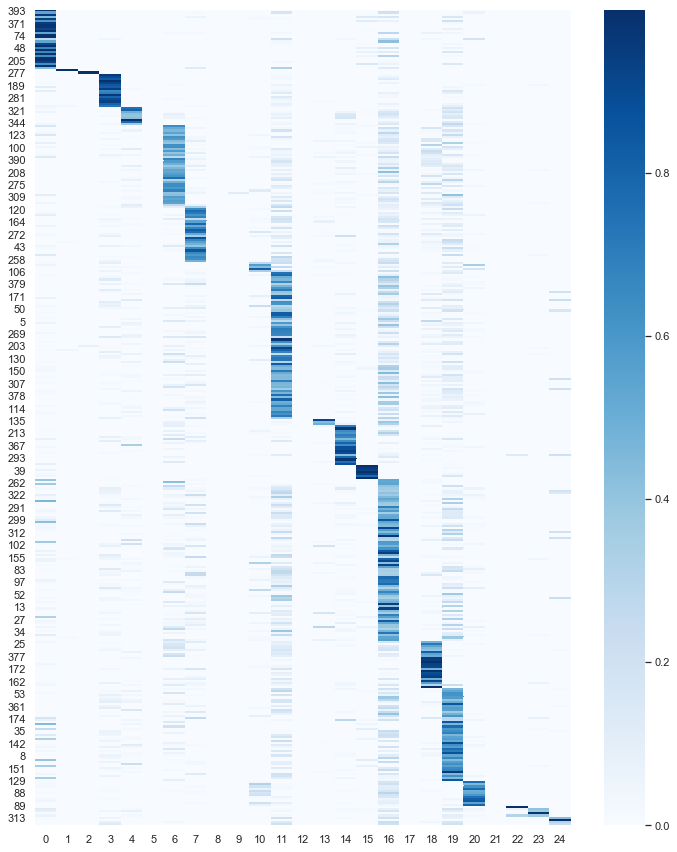

In [30]:
%matplotlib inline
import seaborn as sns; sns.set(rc={'figure.figsize':(12,15)})
sns.heatmap(document_topic.loc[document_topic.idxmax(axis=1).sort_values().index], cmap = 'Blues')

In [69]:
document_topic2 = document_topic

# Combine topic data to book meta data

In [31]:
# define function to get the numbers from rows with strings 
def find_number(text):
    num = re.findall(r'[0-9]+',text)
    return " ".join(num)

In [32]:
document_topic['standard_title'] = book_array

document_topic['book_title_number'] = document_topic['standard_title'].apply(lambda x: find_number(x))

document_topic.head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,standard_title,book_title_number
0,0.373425,0.0,0.0,0.000000,0.000000,0,0.000000,0.000000,0,0.0,...,0,0.000000,0.000000,0.0,0,0.0,0.0,0.0,fBooks/text_38.txt,38
1,0.000000,0.0,0.0,0.040195,0.032073,0,0.000000,0.000000,0,0.0,...,0,0.000000,0.107649,0.0,0,0.0,0.0,0.0,fBooks/text_10.txt,10
2,0.000000,0.0,0.0,0.035696,0.000000,0,0.000000,0.000000,0,0.0,...,0,0.000000,0.671013,0.0,0,0.0,0.0,0.0,fBooks/text_264.txt,264
3,0.083280,0.0,0.0,0.000000,0.000000,0,0.000000,0.000000,0,0.0,...,0,0.000000,0.019329,0.0,0,0.0,0.0,0.0,fBooks/text_270.txt,270
4,0.029675,0.0,0.0,0.000000,0.000000,0,0.129362,0.020345,0,0.0,...,0,0.015171,0.254313,0.0,0,0.0,0.0,0.0,fBooks/text_258.txt,258


In [33]:
# read csv file with the book metadata 
book_metadata = pd.read_csv('List of Books and Authors - metadata.csv')

#book_metadata = book_metadata.set_index('file_number')

book_metadata['book_title_number'] = book_metadata['file_number'].apply(str)

book_metadata.head()

,Author,Book,Image,Year,Description,Buy,Book_old,file_number,book_title_number
0,Adriana Herrera,American Dreamer,https://images-na.ssl-images-amazon.com/images...,2020,No one ever said big dreams come easy\n\nFor N...,https://www.amazon.com/American-Dreamer-Dreame...,American dreamer,221,221
1,Adriana Herrera,American Love Story,https://m.media-amazon.com/images/I/41AY3Khzbl...,2019,No one should have to choose between love and ...,https://www.amazon.com/American-Love-Story-Dre...,American love story,222,222
2,Adriana Herrera,American Sweetheart,https://m.media-amazon.com/images/I/51RJdJyI+t...,2020,Juan Pablo Campos doesn't do regrets. He's liv...,https://www.amazon.com/American-Sweethearts-Dr...,American sweetheart,223,223
3,Adriana Herrera,Finding Joy,https://m.media-amazon.com/images/I/416M8GuOj3...,2020,"As his twenty-sixth birthday approaches, Desta...",https://www.amazon.com/Finding-Joy-Romance-Adr...,Finding joy,224,224
4,Adriana Herrera,Here to Stay,https://m.media-amazon.com/images/I/51ZN1hKljE...,2020,Starting over is more about who you're with th...,https://www.amazon.com/Here-Stay-Adriana-Herre...,Here to stay,225,225


In [34]:
book_df = document_topic.merge(book_metadata, how='outer', right_on = 'book_title_number', left_on = 'book_title_number')

book_df = book_df.set_index('Book')

book_df.head()

,0,1,2,3,4,5,6,7,8,9,...,24,standard_title,book_title_number,Author,Image,Year,Description,Buy,Book_old,file_number
Book,,,,,,,,,,,,,,,,,,,,,
Stepping to a New Day,0.373425,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,fBooks/text_38.txt,38,Beverly Jenkins,https://i.imgur.com/AJuixZy.jpg,2016.0,"In Henry Adams, Kansas, you can't start over w...",https://www.goodreads.com/book/show/27064404-s...,Stepping to a new day,38.0
Her Lover's Legacy,0.000000,0.0,0.0,0.040195,0.032073,0.0,0.000000,0.000000,0.0,0.0,...,0.0,fBooks/text_10.txt,10,Adrianne Byrd,https://m.media-amazon.com/images/I/51QRhQpBff...,2008.0,Heir-apparent Malcolm Braddock may be the sexi...,https://www.amazon.com/gp/product/0373860765/r...,Her lovers legacy,10.0
Island Fling with the Tycoon,0.000000,0.0,0.0,0.035696,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,fBooks/text_264.txt,264,Therese Beharrie,https://m.media-amazon.com/images/I/51Cqm0Ppgn...,2019.0,Could a fairytale weddindlead to her own love ...,https://www.amazon.com/Island-Fling-Tycoon-Har...,Island fling,264.0
The Kingmaker,0.083280,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,fBooks/text_270.txt,270,Kennedy Ryan,https://i.imgur.com/WgtINQb.jpg,2019.0,"Power. Passion. Betrayal. Raised to rule, bred...",https://www.amazon.com/Kingmaker-All-Kings-Due...,The kingmaker,270.0
The Write Escape: An Irish Romance,0.029675,0.0,0.0,0.000000,0.000000,0.0,0.129362,0.020345,0.0,0.0,...,0.0,fBooks/text_258.txt,258,Charish Reid,https://m.media-amazon.com/images/I/419e+vtoBX...,2019.0,Take one heartbroken Chicago girl\n\nLiterary ...,https://www.amazon.com/Write-Escape-Charish-Re...,The write escape,258.0


In [35]:
book_viz = book_df[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
                    22, 23, 24, 'Author', 'Image', 'Year', 'Description', 'Buy']]

book_viz

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,Author,Image,Year,Description,Buy
Book,,,,,,,,,,,,,,,,,,,,,
Stepping to a New Day,0.373425,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.00000,0.000000,Beverly Jenkins,https://i.imgur.com/AJuixZy.jpg,2016.0,"In Henry Adams, Kansas, you can't start over w...",https://www.goodreads.com/book/show/27064404-s...
Her Lover's Legacy,0.000000,0.0,0.0,0.040195,0.032073,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.00000,0.000000,Adrianne Byrd,https://m.media-amazon.com/images/I/51QRhQpBff...,2008.0,Heir-apparent Malcolm Braddock may be the sexi...,https://www.amazon.com/gp/product/0373860765/r...
Island Fling with the Tycoon,0.000000,0.0,0.0,0.035696,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.00000,0.000000,Therese Beharrie,https://m.media-amazon.com/images/I/51Cqm0Ppgn...,2019.0,Could a fairytale weddindlead to her own love ...,https://www.amazon.com/Island-Fling-Tycoon-Har...
The Kingmaker,0.083280,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.00000,0.000000,Kennedy Ryan,https://i.imgur.com/WgtINQb.jpg,2019.0,"Power. Passion. Betrayal. Raised to rule, bred...",https://www.amazon.com/Kingmaker-All-Kings-Due...
The Write Escape: An Irish Romance,0.029675,0.0,0.0,0.000000,0.000000,0.0,0.129362,0.020345,0.0,0.0,...,0.000000,0.0,0.0,0.00000,0.000000,Charish Reid,https://m.media-amazon.com/images/I/419e+vtoBX...,2019.0,Take one heartbroken Chicago girl\n\nLiterary ...,https://www.amazon.com/Write-Escape-Charish-Re...
Higher Love,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.142948,0.068973,0.0,0.0,...,0.000000,0.0,0.0,0.00000,0.000000,Alexandria House,https://m.media-amazon.com/images/I/515nkoL5MK...,2016.0,"Popular travel blogger, Greer Kennedy, is livi...",https://www.amazon.com/Higher-Love-After-Book-...
Go Deep,0.000000,0.0,0.0,0.000000,0.091270,0.0,0.381781,0.098022,0.0,0.0,...,0.000000,0.0,0.0,0.00000,0.000000,Rilzy Adams,https://m.media-amazon.com/images/I/41wKLNq64-...,2020.0,It was all supposed to be so simple. Navaya Ho...,https://www.amazon.com/Go-Deep-Unexpected-Love...
The Sweetest Surrender,0.000000,0.0,0.0,0.000000,0.018052,0.0,0.000000,0.000000,0.0,0.0,...,0.019605,0.0,0.0,0.00000,0.000000,Stephanie Nicole Norris,https://m.media-amazon.com/images/I/51oJyo3-Pb...,2018.0,"Effervescent, Fearless, and self-assured, Sele...",https://www.amazon.com/Sweetest-Surrender-Fall...
His Diamond Queen,0.000000,0.0,0.0,0.062082,0.015639,0.0,0.014627,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.00000,0.000000,Lena Hart,https://m.media-amazon.com/images/I/91E1aODCUc...,2014.0,"Loyalty comes at a cost. Former MMA fighter, J...",https://www.amazon.com/His-Diamond-Queen-Quart...


In [37]:
book_viz['max_val'] = book_viz[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                                17, 18, 19, 20, 21,22, 23, 24]].max(axis=1)
book_viz['max_col'] = book_viz[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                                       17, 18, 19, 20, 21, 22, 23, 24]].idxmax(axis=1)

#document_topic['second_largest'] = document_topic.apply(lambda row: row.nlargest(2).values[-1],axis=1)
book_viz

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,Author,Image,Year,Description,Buy,max_val,max_col
Book,,,,,,,,,,,,,,,,,,,,,
Stepping to a New Day,0.373425,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.00000,0.000000,Beverly Jenkins,https://i.imgur.com/AJuixZy.jpg,2016.0,"In Henry Adams, Kansas, you can't start over w...",https://www.goodreads.com/book/show/27064404-s...,0.590968,16.0
Her Lover's Legacy,0.000000,0.0,0.0,0.040195,0.032073,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.00000,0.000000,Adrianne Byrd,https://m.media-amazon.com/images/I/51QRhQpBff...,2008.0,Heir-apparent Malcolm Braddock may be the sexi...,https://www.amazon.com/gp/product/0373860765/r...,0.445084,16.0
Island Fling with the Tycoon,0.000000,0.0,0.0,0.035696,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.00000,0.000000,Therese Beharrie,https://m.media-amazon.com/images/I/51Cqm0Ppgn...,2019.0,Could a fairytale weddindlead to her own love ...,https://www.amazon.com/Island-Fling-Tycoon-Har...,0.671013,19.0
The Kingmaker,0.083280,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.00000,0.000000,Kennedy Ryan,https://i.imgur.com/WgtINQb.jpg,2019.0,"Power. Passion. Betrayal. Raised to rule, bred...",https://www.amazon.com/Kingmaker-All-Kings-Due...,0.885908,14.0
The Write Escape: An Irish Romance,0.029675,0.0,0.0,0.000000,0.000000,0.0,0.129362,0.020345,0.0,0.0,...,0.0,0.00000,0.000000,Charish Reid,https://m.media-amazon.com/images/I/419e+vtoBX...,2019.0,Take one heartbroken Chicago girl\n\nLiterary ...,https://www.amazon.com/Write-Escape-Charish-Re...,0.496047,16.0
Higher Love,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.142948,0.068973,0.0,0.0,...,0.0,0.00000,0.000000,Alexandria House,https://m.media-amazon.com/images/I/515nkoL5MK...,2016.0,"Popular travel blogger, Greer Kennedy, is livi...",https://www.amazon.com/Higher-Love-After-Book-...,0.278962,11.0
Go Deep,0.000000,0.0,0.0,0.000000,0.091270,0.0,0.381781,0.098022,0.0,0.0,...,0.0,0.00000,0.000000,Rilzy Adams,https://m.media-amazon.com/images/I/41wKLNq64-...,2020.0,It was all supposed to be so simple. Navaya Ho...,https://www.amazon.com/Go-Deep-Unexpected-Love...,0.381781,6.0
The Sweetest Surrender,0.000000,0.0,0.0,0.000000,0.018052,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.00000,0.000000,Stephanie Nicole Norris,https://m.media-amazon.com/images/I/51oJyo3-Pb...,2018.0,"Effervescent, Fearless, and self-assured, Sele...",https://www.amazon.com/Sweetest-Surrender-Fall...,0.710427,11.0
His Diamond Queen,0.000000,0.0,0.0,0.062082,0.015639,0.0,0.014627,0.000000,0.0,0.0,...,0.0,0.00000,0.000000,Lena Hart,https://m.media-amazon.com/images/I/91E1aODCUc...,2014.0,"Loyalty comes at a cost. Former MMA fighter, J...",https://www.amazon.com/His-Diamond-Queen-Quart...,0.537111,19.0


In [38]:
bookData = book_viz.reset_index()
bookData = bookData.reset_index()

# this is the file I use for the app 
bookData.to_csv('books.csv')

# Book recommendation based on LDA

In [39]:
import itertools 

# define functions 
bookList = bookData['Book']
bookIndex = bookData['index']
bookAuthor = bookData['Author']
index2 = similarities.MatrixSimilarity(lda_mod25[corpus])


#userSelection = 6
userSelection = input("Hey, please enter the book you would like to find similar books for: ")

#listOfRelatedBooks = []
corpus_to_compare = []
names_of_related_books = []
identifiedTopic = 55

for book in range(1, 339):
    if userSelection == bookList[book]:
          corpusA = corpus[bookIndex[book]]
          vec_lda = lda_mod25[corpusA]
          corpus_to_compare.append(vec_lda)

sim = index2[vec_lda]
sims = sorted(enumerate(sim), key=lambda item: -item[1])
DoublelistOfRelatedBooks = [list(group) for val, group in itertools.groupby(sims, lambda x: x[1] >= .95) if val]
listOfRelatedBooks = DoublelistOfRelatedBooks[0]

# split tuples into two lists with book name and similarity score 
book_name, score = map(list, zip(*listOfRelatedBooks))

# iterate to get the name of the books and not the book index 
for book in book_name:
     if (bookIndex[book]== book_name).any():
        names_of_related_books.append(bookList[book])
        names_of_related_books.append(' by ' + str(bookAuthor[book]) + '\n')

print("Here's your list:" + '\n' + ''.join(names_of_related_books) + ' ')

print('Happy reading!')


Hey, please enter the book you would like to find similar books for: Get a Life, Chloe Brown
Here's your list:
Get a Life, Chloe Brown by Talia Hibbert
That Kind of Guy by Talia Hibbert
A Girl Like Her by Talia Hibbert
Wanna Bet? by Talia Hibbert
Act Your Age, Eve Brown by Talia Hibbert
Wrapped Up in You by Talia Hibbert
Mating the Huntress: A Halloween Romance by Talia Hibbert
Take a Hint, Dani Brown by Talia Hibbert
Falling for His Convenient Queen by Therese Beharrie
A Valentine Challenge by Kiru Taye
His Princess by Christmas by Therese Beharrie
Secrets by Kiru Taye
Engaged by Kiru Taye
Her Twin Baby Secret by Therese Beharrie
A Wedding One Christmas by Therese Beharrie
 
Happy reading!


# Import Models using Picke

In [40]:
import pickle 

# save the corpus
pickle_out2 = open("corpus.pkl", mode = "wb") 
pickle.dump(corpus, pickle_out2) 
pickle_out2.close()

# save the lda model 
pickle_out = open("lda.pkl", mode = "wb") 
pickle.dump(lda_mod25, pickle_out) 
pickle_out.close()



# LDA using Mallet

In [41]:
import os
from gensim.models.wrappers import LdaMallet


os.environ.update({'MALLET_HOME':'/Users/vclugoar/new_mallet/mallet-2.0.8'})

#os.environ['MALLET_HOME'] = 

mallet_path ='/Users/vclugoar/new_mallet/mallet-2.0.8/bin/mallet'

mallet_lda = LdaMallet(mallet_path, corpus, dictionary, 20, 
                       optimize_interval=10, prefix = 'm_')
                      

CalledProcessError: Command '/Users/vclugoar/new_mallet/mallet-2.0.8/bin/mallet train-topics --input m_corpus.mallet --num-topics Dictionary(42824 unique tokens: ['abandoned', 'abhor', 'ability', 'abject', 'abuela']...)  --alpha 20 --optimize-interval 10 --num-threads 4 --output-state m_state.mallet.gz --output-doc-topics m_doctopics.txt --output-topic-keys m_topickeys.txt --num-iterations 1000 --inferencer-filename m_inferencer.mallet --doc-topics-threshold 0.0  --random-seed 0' returned non-zero exit status 2.